In [1]:
import numpy as np
import pytpc
import matplotlib.pyplot as plt
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.fitting.montecarlo import MCFitter
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
clock = config['clock']
shape = config['shape']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180
electronics_gain = float(config['electronics_gain'])
micromegas_gain = float(config['micromegas_gain'])
diff_sigma = config['diffusion_sigma']
ioniz = 23.0 #eV

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 789
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 300.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[ -99.92520228  -13.97974826  130.99299081  368.63232248 7987.
    8.           14.86637825]


In [5]:
######finding center of curvature#######
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-32.930826913397894 -11.855827208585199


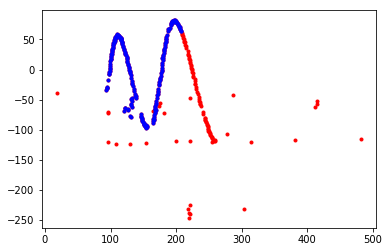

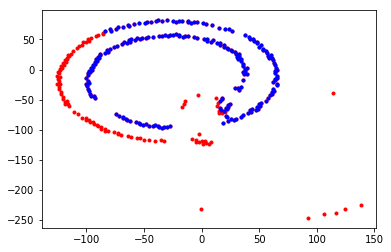

In [6]:
#######plotting real event#########
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [25]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=True)
uvw_values = uvw.values #transform pd file to arrays
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
print(cut_ctr0)

[ 0.          0.          0.52640175  1.49975541 -2.90386441  1.91256674]


In [26]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [27]:
sig = config['sigma']
reduction_factor = 0.8
##### get initial parameter space #####
sigma_init = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*math.pi/180,sig['pol']*math.pi/180])
##### set original candidate to be the seed point #####

In [ ]:
##### set original candidate to be the seed point #####
####### generate a set of parameter vectors within given range #########
min_chi_value = []
min_chi_list = [sigma_init]
candidate = ctr0

for i in range(20): ### number of iteration equals 20
    
    sigma = sigma_init*reduction_factor**float(i)
    print(sigma)

    x = np.random.uniform(low=candidate[0]-sigma[0], high=candidate[0]+sigma[0], size=1000)
    y = np.random.uniform(low=candidate[1]-sigma[1], high=candidate[1]+sigma[1], size=1000)
    z = np.random.uniform(low=candidate[2]-sigma[2], high=candidate[2]+sigma[2], size=1000)
    if candidate[3]-sigma[3] >= 0.0:
        e = np.random.uniform(low=candidate[3]-sigma[3], high=candidate[3]+sigma[3], size=1000)
    else:
        e = np.random.uniform(low=0.0, high=candidate[3]+sigma[3], size=1000)
    a = np.random.uniform(low=candidate[4]-sigma[4], high=candidate[4]+sigma[4], size=1000)
    p = np.random.uniform(low=candidate[5]-sigma[5], high=candidate[5]+sigma[5], size=1000)

    candidates = np.stack((x,y,z,e,a,p),axis=-1)
    
    ##### define variables #####
    sigmaPos = 5.0 ### in mm
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sigmaEng = 0.1
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    
    count = 0
    num = 0
        
    while num-count <= 499.0:

        chi2Pos_x = np.empty((0,0))
        chi2Pos_y = np.empty((0,0))

        try:
            evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2],\
                                       candidates[num][3], candidates[num][4], candidates[num][5])
        except Exception:
            count += 1
            num += 1
            continue

        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                                   baseline_correction=True, cg_times=True)
        sim_xy = sim_xyzs[:, 0:2]
        sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
        sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
        sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
        sim_uvw_values = sim_uvw.values
        
        ##### find energy chi2 #####

        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()

        sigmaEn = np.nanmax(exp_hits)*sigmaEng

        for p in range(10240):        
            if exp_hits[p] != 0:
                if np.isnan(exp_hits[p]) == False:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)

        ##### find Vertex chi2 #####

        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        ##### find position chi2 #####

        f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
        f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

        sim_x = f_x(xyzs[:,2])
        sim_y = f_y(xyzs[:,2])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x))
        sim_x[inds_x] = 0.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y))
        sim_y[inds_y] = 0.0

        chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/float(sigmaPos))    
        chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/float(sigmaPos)) 
        
        Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs)))

        chi2En_per_evt = 0.0
        hit_num = 0.0
        Chi2Vert_per_evt = 0.0
        
        num += 1
        
    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    print(len(Poschi2))
    for i in range(len(Poschi2)):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 0.01:
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)
            print(min_chi_list)
            print(min_chi_value)

print(min_chi_value)
print(min_chi_list)
min_chi_list = np.delete(min_chi_list,0,0)
for i in range(len(min_chi_value)):
    if abs(min_chi_value[i]-min(min_chi_value)) < 0.01:
        print(min_chi_list[i])

[0.1        0.1        0.1        4.         1.04719755 0.52359878]


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice


minimum chi2:343.860488605058
500
[[ 1.00000000e-01  1.00000000e-01  1.00000000e-01  4.00000000e+00
   1.04719755e+00  5.23598776e-01]
 [ 3.09445635e-04 -3.51883006e-03  5.39085427e-01  2.09544329e+00
  -3.46954991e+00  1.87153645e+00]]
[343.860488605058]
[0.08       0.08       0.08       3.2        0.83775804 0.41887902]


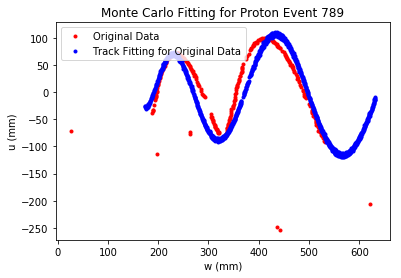

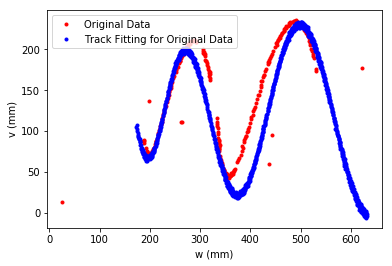

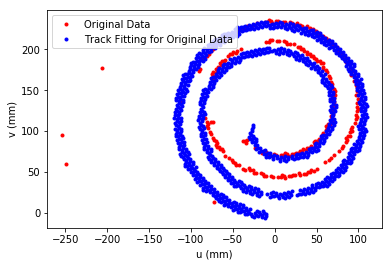

In [34]:
%matplotlib inline
#mcres = [-0.07954585,0.03808574,0.74383587,2.64302064,-3.94825871,1.94771968] #Christina's method-305
#mcres = [0.00618013,0.0156425,0.51365393,2.21270404,-3.37949429,1.92338746] #original method-305
mcres =  [-1.28882482e-02,-3.14978909e-03,6.35100758e-01,2.31233821e+00,-3.28919371e+00,1.93874593e+00]
#mcres =  [2.46638447e-03,2.38112919e-02,6.37331869e-01,1.89648187e+00,-3.17790284e+00,2.02737236e+00] #original-789
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(mcres[0], mcres[1], mcres[2], mcres[3], mcres[4], mcres[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                           baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
#plt.plot(xyzs[:, 2], xyzs[:, 0], 'r.', label='Original Data')
#plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 0], 'b.', label='Track Fitting for Original Data')
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("u (mm)")
plt.title("Monte Carlo Fitting for Proton Event 789")
plt.legend(loc=2)
plt.show()
#plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.', label='Original Data')
#plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 1], 'b.', label='Track Fitting for Original Data')
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()
#plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.', label='Original Data')
#plt.plot(sim_xyzs[:, 0], sim_xyzs[:, 1], 'b.', label='Track Fitting for Original Data')
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()

In [ ]:
##### set original candidate to be the seed point #####
min_chi_value = []
min_chi_list = [sigma_init]
candidate = ctr0
for i in range(20): ### number of iteration equals 20
    
    sigma = sigma_init*reduction_factor**float(i)

    x = np.random.uniform(low=candidate[0]-sigma[0], high=candidate[0]+sigma[0], size=1000)
    y = np.random.uniform(low=candidate[1]-sigma[1], high=candidate[1]+sigma[1], size=1000)
    z = np.random.uniform(low=candidate[2]-sigma[2], high=candidate[2]+sigma[2], size=1000)
    if candidate[3]-sigma[3] >= 0.0:
        e = np.random.uniform(low=candidate[3]-sigma[3], high=candidate[3]+sigma[3], size=1000)
    else:
        e = np.random.uniform(low=0.0, high=candidate[3]+sigma[3], size=1000)
    a = np.random.uniform(low=candidate[4]-sigma[4], high=candidate[4]+sigma[4], size=1000)
    p = np.random.uniform(low=candidate[5]-sigma[5], high=candidate[5]+sigma[5], size=1000)

    candidates = np.stack((x,y,z,e,a,p),axis=-1)
    
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-2
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    sigmaPos = 5.0
    sigmaEng = 0.1
    
    count = 0
    num = 0

    while num-count <= 499.0:

        chi2Pos_x = np.empty((0,0))
        chi2Pos_y = np.empty((0,0))
        
        try:
            evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2],\
                                   candidates[num][3], candidates[num][4], candidates[num][5])
        except Exception:
            count += 1
            num += 1
            continue

        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                                   baseline_correction=True, cg_times=True)

        ##### find energy chi2 #####
        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()
        
        sigmaEn = np.nanmax(exp_hits)*sigmaEng
        
        for p in range(10240):        
            if exp_hits[p] != 0:
                if exp_hits[p] >= 5.0 and hits[p] >= 5.0:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(exp_hits[int(p)])
                    hit_num += 1.0
                else:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(sigmaEn**2)
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/hit_num)

        ##### find vertex chi2 #####
        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        ##### find position chi2 #####
        f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
        f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

        sim_x = f_x(xyzs[:,2])
        sim_y = f_y(xyzs[:,2])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
        sim_x[inds_x] = 0.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
        sim_y[inds_y] = 0.0
        
        for i in range(len(xyzs)):
            if abs(sim_x[i]) >= 5.0 and abs(sim_y[i]) >= 5.0:
                if abs(xyzs[i,0]) >= 5.0 and abs(xyzs[i,1]) >= 5.0:
                    Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/abs(xyzs[i,0])+(xyzs[i,0]-sim_y[i])**2/abs(xyzs[i,1]))
            elif abs(sim_x[i]) >= 5.0 and abs(xyzs[i,0]) >= 5.0:
                Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/abs(xyzs[i,0]) +(xyzs[i,0]-sim_y[i])**2/sigmaPos**2)
            elif abs(sim_y[i]) >= 5.0 and abs(xyzs[i,1]) >= 5.0:
                Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/sigmaPos**2 +(xyzs[i,0]-sim_y[i])**2/abs(xyzs[i,1]))
            else:
                Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/sigmaPos**2 +(xyzs[i,0]-sim_y[i])**2/sigmaPos**2)


        try:
            Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0)
        except Exception:
            Poschi2 = np.append(Poschi2, 1e3)
        
        
        Poschi2_per_evt = np.empty((0,0))
        chi2En_per_evt = 0.0
        Chi2Vert_per_evt = 0.0
        hit_num = 0.0
        
        num += 1

    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    print(len(Poschi2))
    for i in range(len(Poschi2)):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1e-5:
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)
            print(min_chi_list)
            print(min_chi_value)
            print(Poschi2[i])
            print(EngChi2[i])
            print(VertChi2[i])

print(min_chi_value)
print(min_chi_list)
min_chi_list = np.delete(min_chi_list,0,0)
for i in range(len(min_chi_value)):
    if abs(min_chi_value[i]-min(min_chi_value)) < 1e-5:
        print(min_chi_list[i])

In [ ]:
x = np.array([1,2,3])
y = np.array([1,1,1])
z = 1.0-x/y
print(z**2)

In [ ]:

    sigma = sigma_init*reduction_factor**float(i)
    num_events = 100
    candidates = [sigma]
    print(candidate)
    while len(candidates) <= 501.0:
        pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                                   beam_origin_z, gas, num_events)
        for evt in pgen:
            p = evt[0]
            try:
                if abs(p[0]-candidate[0]) >= sigma[0]:
                    raise ValueError
                elif abs(p[1]-candidate[1]) >= sigma[1]:
                    raise ValueError
                elif abs(p[2]-candidate[2]) >= sigma[2]:
                    raise ValueError
                elif abs(p[3]-candidate[3]) >= sigma[3]:
                    raise ValueError
                elif abs(p[4]-candidate[4]) >= sigma[4]:
                    raise ValueError
                elif abs(p[5]-candidate[5]) >= sigma[5]:
                    raise ValueError
            except ValueError:
                continue
            candidates = np.append(candidates, [p], axis=0)
    candidates = np.delete(candidates,0,0)
    
#        for i in range(len(xyzs)):
#            if np.isnan(sim_x[i]) == False:
#                if np.isnan(sim_y[i]) == False:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
#        try:
#            Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0)
#        except Exception:
#            Poschi2 = np.append(Poschi2, 1e3)

#        for i in range(len(xyzs)):
#            if abs(sim_x[i]/xyzs[i,0]) <= 1.0:
#                if abs(sim_y[i]/xyzs[i,1]) <= 1.0:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i])**2/abs(xyzs[i,0])+\
#                                                                    (1.0-sim_y[i])**2/abs(xyzs[i,1]))
#                else:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i])**2/abs(xyzs[i,0])+\
#                                                                    (1.0-xyzs[i,1])**2/abs(sim_y[i]))
#            else:
#                if abs(sim_y[i]/xyzs[i,1]) <= 1.0:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-xyzs[i,0])**2/abs(sim_x[i])+\
#                                                                    (1.0-sim_y[i])**2/abs(xyzs[i,1]))
#                else:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-xyzs[i,0])**2/abs(sim_x[i])+\
#                                                                    (1.0-xyzs[i,1])**2/abs(sim_y[i]))

#        Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(xyzs))/2.0)